In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

In [2]:
from torchvision import datasets, transforms

mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)

In [3]:
print("Number of MNIST training examples: {}".format(len(mnist_train)))
print("Number of MNIST test examples: {}".format(len(mnist_test)))

Number of MNIST training examples: 60000
Number of MNIST test examples: 10000


Default image shape: torch.Size([1, 28, 28])
Reshaped image shape: torch.Size([28, 28])
The label for this image: 1


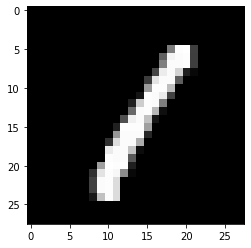

In [12]:
image, label = mnist_train[3] # pick the 4th example
# plot the image
print("Default image shape: {}".format(image.shape))
image = image.reshape([28, 28])
print("Reshaped image shape: {}".format(image.shape))
plt.imshow(image, cmap="gray")
# print the label
print("The label for this image: {}".format(label))

In [13]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

In [14]:
data_train_iter = iter(train_loader)
images, labels = data_train_iter.next()

print("Shape of the minibatch of images: {}".format(images.shape))
print("Shape of the minibatch of labels: {}".format(labels.shape))

Shape of the minibatch of images: torch.Size([100, 1, 28, 28])
Shape of the minibatch of labels: torch.Size([100])


In [15]:
x = images.view(-1, 28*28)
print("The shape of input x: {}".format(x.shape))

The shape of input x: torch.Size([100, 784])


In [16]:
# Randomly initialize weights w
w = torch.randn(784, 10)/np.sqrt(784)
w.requires_grad_()

# Initialize bias b as 0s
b = torch.zeros(10, requires_grad=True)

In [17]:
# linear transformation with w and b
y = torch.matmul(x, w) + b

In [18]:
print(y[0,:])

tensor([-0.6922,  0.3899,  0.1176, -0.0103,  0.3091,  0.1735,  0.0715, -0.6122,
        -0.1967,  0.2389], grad_fn=<SliceBackward0>)


In [20]:
# option 1: softmax to probabilities from equation.
py_eq = torch.exp(y)/torch.sum(torch.exp(y), dim=1, keepdim=True)
print("py[0] from equation: {}".format(py_eq[0]))

# option 2: softmax to probabilities with torch.nn.functional
import torch.nn.functional as F
py = F.softmax(y, dim=1)
print("py[0] with torch.nn.functional.softmax: {}".format(py[0]))

py[0] from equation: tensor([0.0483, 0.1427, 0.1087, 0.0956, 0.1316, 0.1149, 0.1038, 0.0524, 0.0794,
        0.1227], grad_fn=<SelectBackward0>)
py[0] with torch.nn.functional.softmax: tensor([0.0483, 0.1427, 0.1087, 0.0956, 0.1316, 0.1149, 0.1038, 0.0524, 0.0794,
        0.1227], grad_fn=<SelectBackward0>)


In [21]:
print(labels.shape)

torch.Size([100])


In [22]:
# Cross-entropy loss from equation
cross_entropy_eq = torch.mean(-torch.log(py_eq)[range(labels.shape[0]), labels])
print("cross entropy from equation: {}".format(cross_entropy_eq))

# Optional 2: cross-entropy loss with torch.nn.functional
cross_entropy = F.cross_entropy(y, labels)
print("cross entropy with torch.nn.functional.cross_entropy: {}".format(cross_entropy))

cross entropy from equation: 2.4640347957611084
cross entropy with torch.nn.functional.cross_entropy: 2.4640347957611084


In [24]:
# Optimizer
optimizer = torch.optim.SGD([w,b], lr=0.1)

In [25]:
cross_entropy.backward()

In [26]:
b.grad

tensor([-0.0672,  0.0137,  0.0001, -0.0162,  0.0139,  0.0268,  0.0015, -0.0216,
         0.0030,  0.0460])

In [27]:
optimizer.step()

In [28]:
b

tensor([ 6.7205e-03, -1.3691e-03, -1.2528e-05,  1.6165e-03, -1.3856e-03,
        -2.6756e-03, -1.4811e-04,  2.1632e-03, -3.0432e-04, -4.6049e-03],
       requires_grad=True)

In [29]:
print("b.grad before zero_grad(): {}".format(b.grad))
optimizer.zero_grad()
print("b.grad after zero_grad(): {}".format(b.grad))

b.grad before zero_grad(): tensor([-0.0672,  0.0137,  0.0001, -0.0162,  0.0139,  0.0268,  0.0015, -0.0216,
         0.0030,  0.0460])
b.grad after zero_grad(): tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [30]:
# Iterate through train set minibatchs
for images, labes in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = torch.matmul(x, w) + b
    cross_entropy = F.cross_entropy(y, labels)
    # Backward pass
    cross_entropy.backward()
    optimizer.step()

  0%|          | 0/600 [00:00<?, ?it/s]

In [34]:
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibtchs
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = torch.matmul(x, w) + b
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())

print('Test accuracy: {}'.format(correct/total))

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 0.9021000266075134


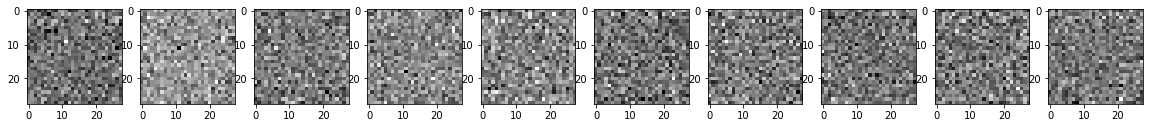

In [32]:
# Get weights
fig, ax = plt.subplots(1, 10, figsize=(20, 2))

for digit in range(10):
    ax[digit].imshow(w[:,digit].detach().view(28, 28), cmap='gray')

In [33]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

# Load the data
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

## Training
# Initialize parameters
w = torch.randn(784, 10)/np.sqrt(784)
w.requires_grad_()

# Optimizer
optimizer = torch.optim.SGD([w, b], lr=0.1)

# Iterate through train set minibatchs
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = torch.matmul(x, w) + b
    cross_entropy = F.cross_entropy(y, labels)
    # Backward pass
    cross_entropy.backward()
    optimizer.step()
    
## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = torch.matmul(x, w) + b
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
        
print('Test accuracy: {}'.format(correct/total))

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 0.9021000266075134


In [41]:
class xW_plus_b:
    def __init__(self, dim_in, dim_out):
        self.w = torch.randn(dim_in, dim_out)/ np.sqrt(dim_in)
        self.w.requires_grad_()
        self.b = torch.zeros(dim_out, requires_grad=True)
        
    def forward(self, x):
        return torch.matmul(x, self.w) + self.b

In [42]:
# example
lin_custom = xW_plus_b(784, 10)
print("w: {}".format(lin_custom.w.shape))
print("b: {}".format(lin_custom.b.shape))

w: torch.Size([784, 10])
b: torch.Size([10])


In [43]:
# linear transform example
x_rand = torch.randn(1, 784)
y = lin_custom.forward(x_rand)
print(y.shape)

torch.Size([1, 10])


In [44]:
import torch.nn as nn

In [45]:
lin = nn.Linear(784, 10)
print("Linear parameters: {}".format([p.shape for p in lin.parameters()]))

y = lin(x_rand)
print(y.shape)

Linear parameters: [torch.Size([10, 784]), torch.Size([10])]
torch.Size([1, 10])


In [46]:
class MNIST_Logistic_Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
        
    def forward(self, x):
        return self.lin(x)

In [47]:
model = MNIST_Logistic_Regression()
y = model(x_rand)
print("The model: \n{}".format(model))
print("\nParameters: \n{}".format(list(model.parameters())))
print("\nOutput shape: \n{}".format(y.shape))

The model: 
MNIST_Logistic_Regression(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

Parameters: 
[Parameter containing:
tensor([[ 0.0202, -0.0059,  0.0325,  ...,  0.0299,  0.0051, -0.0044],
        [-0.0214, -0.0261, -0.0184,  ...,  0.0167, -0.0194, -0.0156],
        [-0.0184,  0.0114,  0.0116,  ..., -0.0310,  0.0255,  0.0307],
        ...,
        [-0.0232, -0.0015,  0.0157,  ..., -0.0177,  0.0224, -0.0219],
        [-0.0287,  0.0348,  0.0237,  ..., -0.0134,  0.0343, -0.0259],
        [-0.0141,  0.0062,  0.0272,  ..., -0.0072,  0.0116,  0.0304]],
       requires_grad=True), Parameter containing:
tensor([ 0.0066,  0.0287, -0.0112,  0.0331, -0.0152, -0.0069, -0.0140,  0.0138,
         0.0058, -0.0154], requires_grad=True)]

Output shape: 
torch.Size([1, 10])


In [49]:
# full code...
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

class MNIST_Logistic_Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
        
    def forward(self, x):
        return self.lin(x)
    
# Load the data
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

## Training
# Instantiate model
model = MNIST_Logistic_Regression()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Iterate throught rain set minibatchs
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = model(x)
    loss = criterion(y, labels)
    # Backward pass
    loss.backward()
    optimizer.step()
## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = model(x)
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
        
print('Test accuracy: {}'.format(correct/total))

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 0.9021000266075134
